In [1]:
from model import Network
from data import load_cifar10_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from metrics import lpips, psnr

# reproducibility
random_seed = 2024

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)

In [2]:
# load to model
model_config = './model_config/fc1_cocktail_party_cifar10_instance.json'
checkpoint_path = './checkpoints/122123_fc1_cocktail_party_cifar10_pretraining_wout_bias_wout_normalization.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# get val loader
batch_size = 8
data_path = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
])

_, val_dataloader = load_cifar10_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

/home/gulerlab/miniconda3/envs/pytorch-scipy/lib/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Files already downloaded and verified
Files already downloaded and verified


In [3]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([10, 3072])]


In [4]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [5]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(32, 32, 3, 1.5598034929652145, 7.916385923698705, 0.49341174306577273)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 2.1851329803466797
loss: 0.6132137775421143
loss: 0.5147523880004883
loss: 0.5100428462028503
loss: 0.507193922996521
loss: 0.5075404644012451
loss: 0.5050680041313171
loss: 0.506515622138977
loss: 0.5068762302398682
loss: 0.5050061345100403
loss: 0.5058788657188416
loss: 0.5076947808265686
loss: 0.5055888891220093
loss: 0.5046704411506653
loss: 0.5058259963989258
loss: 0.5055134296417236
loss: 0.5053873062133789
loss: 0.5067590475082397
loss: 0.5042805075645447
loss: 0.5063789486885071
loss: 0.5051690340042114
loss: 0.5066483020782471
loss: 0.5060023665428162
loss: 0.5068197250366211
loss: 0.5051997900009155
loss: 0.5057422518730164


In [6]:
unmixing_matrix = unmixing_matrix.detach().to('cpu')
whitened_gradient = whitened_gradient.detach().to('cpu')

## PSNR Values

In [7]:
with torch.no_grad():
    psnr_match, psnr_is_positive, mean_psnr = psnr(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [8]:
psnr_match

[tensor([7, 7]),
 tensor([6, 5]),
 tensor([3, 3]),
 tensor([2, 1]),
 tensor([4, 2]),
 tensor([1, 4]),
 tensor([5, 0]),
 tensor([0, 6])]

In [9]:
mean_psnr

10.064017593860626

In [10]:
psnr_is_positive

[True, True, True, False, True, True, False, False]

## LPIPS

In [29]:
with torch.no_grad():
    lpips_match, lpips_is_positive, mean_lpips = lpips(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [30]:
lpips_match

[tensor([0, 4]),
 tensor([2, 3]),
 tensor([6, 7]),
 tensor([7, 5]),
 tensor([1, 0]),
 tensor([3, 2]),
 tensor([5, 1]),
 tensor([4, 6])]

In [31]:
mean_lpips

0.05111221387051046

In [32]:
lpips_is_positive

[False, False, False, True, False, False, False, False]

## Estimated images

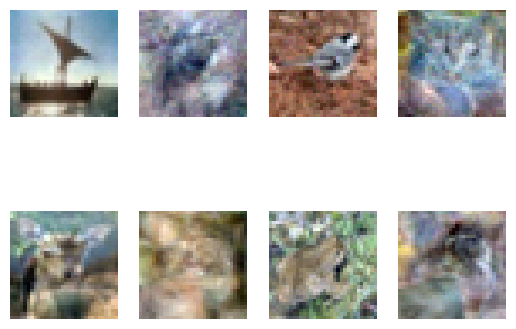

In [37]:
with torch.no_grad():
    estimated_img = (unmixing_matrix @ whitened_gradient)
    
    fig, axes = plt.subplots(2, 4)
    
    for estimate, ax, is_positive in zip(estimated_img, axes.flatten(), lpips_is_positive):
        estimate_coeff = 1 if is_positive else -1
        img = colors.Normalize()(np.asarray(estimate_coeff * estimate).reshape(3, 32, 32).transpose(1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
    plt.show()

## Original images

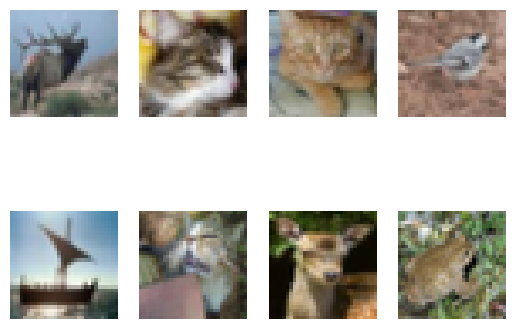

In [18]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 4)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()